In [3]:
# Following this guide: https://scikit-learn.org/stable/auto_examples/cluster/plot_hdbscan.html
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.cluster import DBSCAN, HDBSCAN
from sklearn.datasets import make_blobs
from sklearn import preprocessing

import polars as pl

/home/ubuntu/thesis-da/lib/python3.10/site-packages/polars/_cpu_check.py:239: RuntimeWarning: Missing required CPU features.

The following required CPU features were not detected:
    ssse3, sse4.1, sse4.2, popcnt
Continuing to use this version of Polars on this processor will likely result in a crash.
Install the `polars-lts-cpu` package instead of `polars` to run Polars with better compatibility.

Hint: If you are on an Apple ARM machine (e.g. M1) this is likely due to running Python under Rosetta.
It is recommended to install a native version of Python that does not run under Rosetta x86-64 emulation.

If you believe this warning to be a false positive, you can set the `POLARS_SKIP_CPU_CHECK` environment variable to bypass this check.

  warnings.warn(


In [4]:
def plot(X, labels, probabilities=None, parameters=None, ground_truth=False, ax=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 4))
    labels = labels if labels is not None else np.ones(X.shape[0])
    probabilities = probabilities if probabilities is not None else np.ones(X.shape[0])
    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    # The probability of a point belonging to its labeled cluster determines
    # the size of its marker
    proba_map = {idx: probabilities[idx] for idx in range(len(labels))}
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_index = np.where(labels == k)[0]
        for ci in class_index:
            ax.plot(
                X[ci, 0],
                X[ci, 1],
                "x" if k == -1 else "o",
                markerfacecolor=tuple(col),
                markeredgecolor="k",
                markersize=4 if k == -1 else 1 + 5 * proba_map[ci],
            )
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    preamble = "True" if ground_truth else "Estimated"
    title = f"{preamble} number of clusters: {n_clusters_}"
    if parameters is not None:
        parameters_str = ", ".join(f"{k}={v}" for k, v in parameters.items())
        title += f" | {parameters_str}"
    ax.set_title(title)
    plt.tight_layout()

In [5]:
dlp = pl.read_csv("../data/prepared/tokenized_data.csv")

In [6]:
dlp.head(2)

userAgent-token,eventType-token,eventName-token,eventSource-token,recipientAccountId-token,awsRegion-token,eventVersion-token
i64,i64,i64,i64,i64,i64,i64
3827,2,594,100,0,13,2
3827,2,594,100,0,3,2


In [7]:
X_train, X_test = dlp[0:1000].to_numpy(), dlp[1000:2000].to_numpy()

In [8]:
scaler = preprocessing.StandardScaler().fit(X_train)

In [9]:
X_t_scaled = scaler.transform(X_train)

<Axes: >

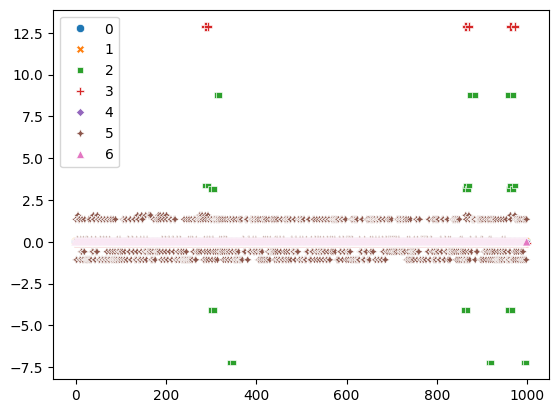

In [10]:
sns.scatterplot(X_t_scaled)

In [11]:
dbs = DBSCAN(eps=3)

In [12]:
X_t_scaled_max, X_t_scaled_min = np.max(X_t_scaled), np.min(X_t_scaled)

(X_t_scaled_max, X_t_scaled_min)

(12.87115638420521, -7.214066223944405)

In [13]:
min_max_sequence = np.arange(X_t_scaled_min, X_t_scaled_max, 1)

In [14]:
min_max_sequence

array([-7.21406622, -6.21406622, -5.21406622, -4.21406622, -3.21406622,
       -2.21406622, -1.21406622, -0.21406622,  0.78593378,  1.78593378,
        2.78593378,  3.78593378,  4.78593378,  5.78593378,  6.78593378,
        7.78593378,  8.78593378,  9.78593378, 10.78593378, 11.78593378,
       12.78593378])

/tmp/ipykernel_28069/2265855999.py:34: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()
/tmp/ipykernel_28069/2265855999.py:34: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()
/tmp/ipykernel_28069/2265855999.py:34: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


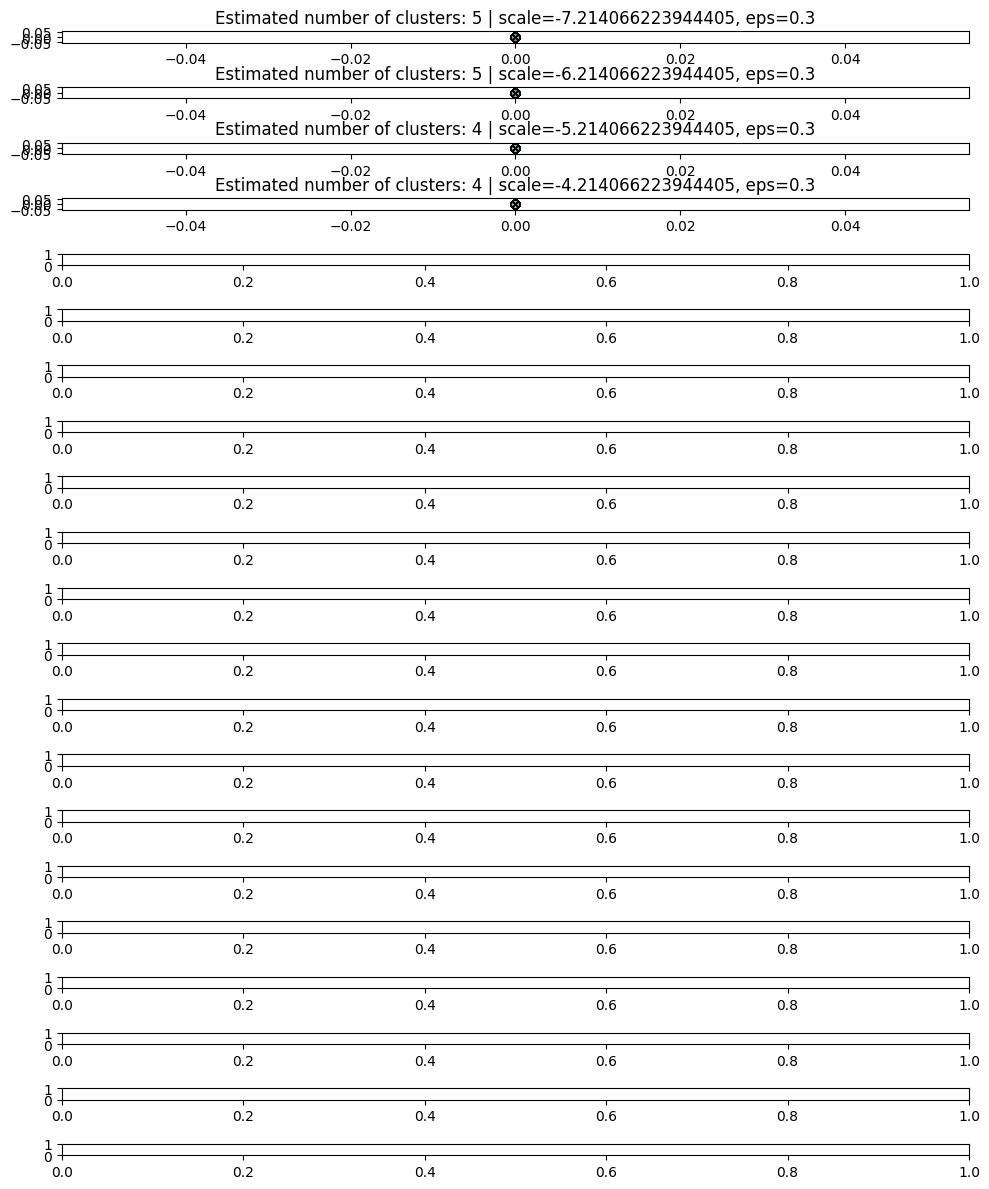

In [15]:
fig, axes = plt.subplots(min_max_sequence.shape[0], 1, figsize=(10,12))

for idx, scale in enumerate(min_max_sequence[:4]):
    dbs.fit(X_t_scaled * scale)
    plot(X_t_scaled * scale, dbs.labels_, parameters={"scale": scale, "eps": 0.3}, ax=axes[idx])